In [ ]:
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
from glob import glob
import sys
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import seaborn as sns

In [2]:
training_path = "../input/paddy-disease-classification/train_images"
testing_path = "../input/paddy-disease-classification/test_images"

In [3]:
image_count = len(list(pathlib.Path(training_path).glob('*/*.jpg')))
print(image_count)

10407


In [4]:
training_data = tf.keras.utils.image_dataset_from_directory(
    training_path,
    validation_split = 0.1,  # fraction will be needed for validation
    seed = 48,
    subset='training',
    label_mode='categorical',
)

Found 10407 files belonging to 10 classes.
Using 9367 files for training.


2022-08-09 23:04:25.603399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 23:04:25.728374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 23:04:25.729183: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 23:04:25.731700: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
validation_data = tf.keras.utils.image_dataset_from_directory(
    training_path,
    validation_split = 0.1,
    seed = 48,
    subset='validation',
    label_mode='categorical',
)

Found 10407 files belonging to 10 classes.
Using 1040 files for validation.


In [6]:
class_names = training_data.class_names
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [13]:
training_data.take(1)

<TakeDataset shapes: ((None, 256, 256, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [14]:
# Here are the first nine images from the training dataset:

# plt.figure(figsize=(10, 10))
# for images, labels in training_data.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis("off")

**Model Creation**

In [18]:
# These days, convnets are rarely trained from scratch. More often, we reuse the base of a pretrained model.
# Reusing a pretrained model is a technique known as transfer learning
base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, 
    weights = 'imagenet',
    input_shape = (256, 256, 3) )

In [19]:
base_model.trainable = False

In [20]:
# if we augment our training data with flipped images, our classifier will learn that 
# "left or right",some rotation, some shape different,etc are differences it should ignore
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomTranslation(height_factor = 0.1, width_factor = 0.1),
    tf.keras.layers.RandomContrast(factor = 0.1)]
)

In [21]:
# because our output has 10 classes.
prediction_layer = tf.keras.layers.Dense(10, activation = "softmax")

In [ ]:
# !pip install -U keras keras-applications

In [22]:
# convolutional neural network building.
# 1. Augmentation
# 2. convolution using pretrained model
# 3. head part of convolution network of 2 dense layers 
#    (droping used here to avoid overfitting and 
#     normalization used here to rescaling data in between the network)
# 4. finally output layer.
inputs = tf.keras.Input((256, 256, 3))
x = data_augmentation(inputs)

x = tf.keras.applications.inception_resnet_v2.preprocess_input(x)
x = base_model(x, training = False)
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)

In [23]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

**Training 1**

In [24]:
# optimizer used is RMSprop here, loss function cross entropy.
model.compile(
  loss=tf.keras.losses.CategoricalCrossentropy(),
  optimizer=tf.keras.optimizers.RMSprop(),
  metrics=['accuracy']
)

In [25]:
# to avoid overfitting and underfitting. 
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, mode='auto', restore_best_weights=True)

In [ ]:
# tf.config.run_functions_eagerly(True)


In [26]:
model_history = model.fit(training_data, validation_data = validation_data, batch_size = 32, epochs = 100, callbacks=[early_stop])

Epoch 1/100


2022-08-09 23:12:41.423876: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


293/293 [==============================] - 79s 209ms/step - loss: 1.8056 - accuracy: 0.3811 - val_loss: 1.4362 - val_accuracy: 0.5231
Epoch 2/100
293/293 [==============================] - 50s 169ms/step - loss: 1.4659 - accuracy: 0.4976 - val_loss: 1.2184 - val_accuracy: 0.6087
Epoch 3/100
293/293 [==============================] - 50s 167ms/step - loss: 1.3234 - accuracy: 0.5514 - val_loss: 1.2180 - val_accuracy: 0.6087
Epoch 4/100
293/293 [==============================] - 51s 170ms/step - loss: 1.2421 - accuracy: 0.5789 - val_loss: 1.1371 - val_accuracy: 0.6279
Epoch 5/100
293/293 [==============================] - 49s 166ms/step - loss: 1.1870 - accuracy: 0.6029 - val_loss: 1.0770 - val_accuracy: 0.6500
Epoch 6/100
293/293 [==============================] - 50s 167ms/step - loss: 1.1384 - accuracy: 0.6138 - val_loss: 0.9147 - val_accuracy: 0.6942
Epoch 7/100
293/293 [==============================] - 49s 166ms/step - loss: 1.0790 - accuracy: 0.6365 - val_loss: 0.9498 - val_accurac

In [27]:
model.save("resIncep.h5")

Minimum validation loss: 0.5611981749534607


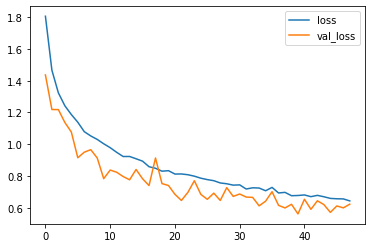

In [28]:
history_df = pd.DataFrame(model_history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

If we see graph then minimum gap between val_loss and loss is near about 16th epoch
but not exactly so we consider minimum one

Minimum validation accuracy: 0.5230769515037537


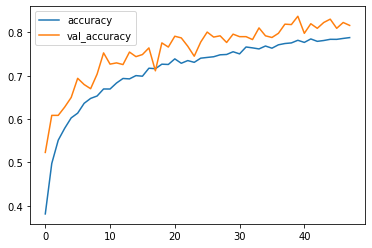

In [33]:
history_df.loc[:, ['accuracy', 'val_accuracy']].plot();
print("Minimum validation accuracy: {}".format(history_df['val_accuracy'].min()))

**Loading Saved Model**

In [29]:
loaded_model = tf.keras.models.load_model('../input/paddy-disease-premodel/resIncep.h5')

In [32]:
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 256, 256, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 55296)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               7078

**Verification**

In [35]:
result2 = loaded_model.evaluate(training_data)

293/293 [==============================] - 42s 141ms/step - loss: 0.4198 - accuracy: 0.8667


In [ ]:
print(f"Loss: {result2[0]}")
print(f"Accuracy: {result2[1] * 100}")

In [34]:
result3 = loaded_model.evaluate(validation_data)
print(f"Loss: {result3[0]}")
print(f"Accuracy: {result3[1] * 100}")

33/33 [==============================] - 5s 143ms/step - loss: 0.5612 - accuracy: 0.8375
Loss: 0.5611981749534607
Accuracy: 83.74999761581421


**Submission**

In [36]:
testing_data = tf.keras.utils.image_dataset_from_directory(
    testing_path,
    seed = 48,
    labels = None,
    shuffle = False
)

Found 3469 files belonging to 1 classes.


In [37]:
predictions = loaded_model.predict(testing_data)
predictions.shape

(3469, 10)

In [38]:
ss = pd.read_csv('../input/paddy-disease-classification/sample_submission.csv')
ss['label'] = np.argmax(predictions, axis=-1)
ss['label'] = ss['label'].replace([0,1,2,3,4,5,6,7,8,9], training_data.class_names)
ss.to_csv("Submission.csv",index=False)
ss.head()

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,downy_mildew
3,200004.jpg,blast
4,200005.jpg,blast


**Training2**

In [ ]:

loaded_model.compile(
  loss=tf.keras.losses.CategoricalCrossentropy(),
  optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.0001),
  metrics=['accuracy']
)

In [ ]:
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, min_delta = 0.001, mode='auto', restore_best_weights=True)

In [ ]:
checkpoint_1 = tf.keras.callbacks.ModelCheckpoint(filepath = 'best_weights.hdf5',
                                  save_best_only = True)


In [ ]:
model_history = loaded_model.fit(training_data, validation_data = validation_data, batch_size = 32, epochs = 100, callbacks=[checkpoint_1, early_stop])

In [ ]:
loaded_model2 = tf.keras.models.load_model('./best_weights.hdf5')

In [ ]:
checkpoint_2 = tf.keras.callbacks.ModelCheckpoint(filepath = 'best_weights2.hdf5',
                                  save_best_only = True)


In [ ]:
loaded_model2.compile(
  loss=tf.keras.losses.CategoricalCrossentropy(),
  optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.0001),
  metrics=['accuracy']
)

In [ ]:
model_history = loaded_model2.fit(training_data, validation_data = validation_data, batch_size = 32, epochs = 100, callbacks=[checkpoint_2])

In [ ]:
result4 = loaded_model2.evaluate(validation_data)
print(f"Loss: {result4[0]}")
print(f"Accuracy: {result4[1] * 100}")

**Plotting**

In [ ]:
#PLotting the graph between epochs loss for loss and val_loss

sns.lineplot(x = range(len(model_history.history["loss"])), y = model_history.history["loss"], label = "Training")
sns.lineplot(x = range(len(model_history.history["loss"])), y = model_history.history["val_loss"], label = "Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
#PLotting the graph between epochs loss for accuracy and val_accuracy

sns.lineplot(x = range(len(model_history.history["loss"])), y = model_history.history["accuracy"], label = "Training")
sns.lineplot(x = range(len(model_history.history["loss"])), y = model_history.history["val_accuracy"], label = "Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc = "lower right")

**Submission**

In [ ]:
loaded_model3 = tf.keras.models.load_model('./best_weights2.hdf5')

In [ ]:
result5 = loaded_model3.evaluate(validation_data)
print(f"Loss: {result5[0]}")
print(f"Accuracy: {result5[1] * 100}")

In [ ]:
predictions2 = loaded_model2.predict(testing_data)
predictions2.shape

In [ ]:
predictions3 = loaded_model3.predict(testing_data)
predictions3.shape

In [ ]:
ss = pd.read_csv('../input/paddy-disease-classification/sample_submission.csv')
ss['label'] = np.argmax(predictions2, axis=-1)
ss['label'] = ss['label'].replace([0,1,2,3,4,5,6,7,8,9], training_data.class_names)
ss.to_csv("Submission2.csv",index=False)
ss.head()

In [ ]:
ss = pd.read_csv('../input/paddy-disease-classification/sample_submission.csv')
ss['label'] = np.argmax(predictions3, axis=-1)
ss['label'] = ss['label'].replace([0,1,2,3,4,5,6,7,8,9], training_data.class_names)
ss.to_csv("Submission3.csv",index=False)
ss.head()

**Training3**

In [ ]:
checkpoint_4 = tf.keras.callbacks.ModelCheckpoint(filepath = 'best_weights4.hdf5',
                                  save_best_only = True)

In [ ]:

loaded_model4.compile(
  loss=tf.keras.losses.CategoricalCrossentropy(),
  optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.0005),
  metrics=['accuracy']
)

In [ ]:
model_history = loaded_model4.fit(training_data, validation_data = validation_data, batch_size = 32, epochs = 50, callbacks=[checkpoint_4])

In [ ]:
result5 = loaded_model3.evaluate(validation_data)
print(f"Loss: {result5[0]}")
print(f"Accuracy: {result5[1] * 100}")

In [ ]:
# result5 = loaded_model2.evaluate(validation_data)
print(f"Loss: {result4[0]}")
print(f"Accuracy: {result4[1] * 100}")

In [ ]:
loaded_model4 = tf.keras.models.load_model('./best_weights3.hdf5')

In [ ]:
result6 = loaded_model4.evaluate(validation_data)
print(f"Loss: {result6[0]}")
print(f"Accuracy: {result6[1] * 100}")